Generating data input for daily coefficients, PV capacity factor and demand Y

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import random

Import data from PVGIS file and find min anc max in TMY

In [2]:
# Import data from csv
data_path = 'Siracusa_PVGIS.csv'
df = pd.read_csv(data_path, skiprows=10, delimiter=',', low_memory=False)
df = df.iloc[:-10]

# Select desired dataframes and create a the raw data DataFrame
raw = df[['time', 'P']].copy()
raw['P'] = pd.to_numeric(raw['P'], errors='coerce')

# Handle timestamp
raw['time'] = pd.to_datetime(raw['time'], format='%Y%m%d:%H%M')
raw['Year'] = raw['time'].dt.year
raw['Month'] = raw['time'].dt.month
raw['Day'] = raw['time'].dt.day
raw['Date'] = raw['time'].dt.strftime('%Y%m%d')
raw['Hour'] = raw['time'].dt.hour

seasons=['winter', 'mid-cold', 'mid-warm', 'summer']
# Remove 29th February
raw = raw[~((raw['Month'] == 2) & (raw['Day'] == 29))]
raw['doy'] = raw['time'].dt.dayofyear

# Define seasons
def get_season(day):
    if 1 <= day <= 74 or 335 <= day <= 366:
        return 'winter'
    elif 75 <= day <= 90 or 305 <= day <= 334:
        return 'mid-cold'
    elif 91 <= day <= 135 or 259 <= day <= 304:
        return 'mid-warm'
    elif 136 <= day <= 258:
        return 'summer'
    else:
        return 'unknown'
    
raw['Season'] = raw['doy'].apply(get_season)

#Typical year generation-------------------------------------------------------
# Monthly avarages
monthly_means = raw.groupby(['Month', 'Hour'])['P'].mean().reset_index()
typical_year = {}
for month in range(1, 13):
     month_data = raw[raw['Month'] == month]
    
     #Evaluate distance of monthly avarage for each year
     year_distances = {}
     for year in month_data['Year'].unique():
         year_data = month_data[month_data['Year'] == year]
         hourly_means = year_data.groupby('Hour')['P'].mean()
        
        # Allign index
         hourly_means = hourly_means.reindex(monthly_means[monthly_means['Month'] == month]['Hour'].values, fill_value=0)
         distance = ((hourly_means - monthly_means[monthly_means['Month'] == month]['P'].values) ** 2).sum()
         year_distances[year] = distance
    
     # Select year with min distance
     typical_year[month] = min(year_distances, key=year_distances.get)

#Unite
typical_year_data_list = []
for month, year in typical_year.items():
    month_data = raw[(raw['Year'] == year) & (raw['Month'] == month)]
    typical_year_data_list.append(month_data)

# Concatenazione dei dati in un unico DataFrame
typical_year_data = pd.concat(typical_year_data_list)
# Sort by timestamp
typical_year_data = typical_year_data.sort_values(by='time')
    

#Giorni di produzione minima e massima del TMY
# Calcolare la produzione giornaliera
daily_productionTMY = typical_year_data.groupby(['Date', 'Season'])['P'].sum().reset_index()

# Identificare i giorni di produzione minima e massima per ciascuna stagione
min_prod_dates = {}
max_prod_dates={}
for season in typical_year_data['Season'].unique():
    season_df = daily_productionTMY[daily_productionTMY['Season'] == season]
    min_prod_dates[season]=season_df.loc[season_df['P'].idxmin()]['Date']
    max_prod_dates[season]=season_df.loc[season_df['P'].idxmax()]['Date']

Clustering

/var/folders/7_/h7wd3zm54kg_zntp92069r1h0000gn/T/ipykernel_66713/1641798110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['P'] = X['P'].fillna(0)
/var/folders/7_/h7wd3zm54kg_zntp92069r1h0000gn/T/ipykernel_66713/1641798110.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['data'] = pd.to_datetime(X['Date'])


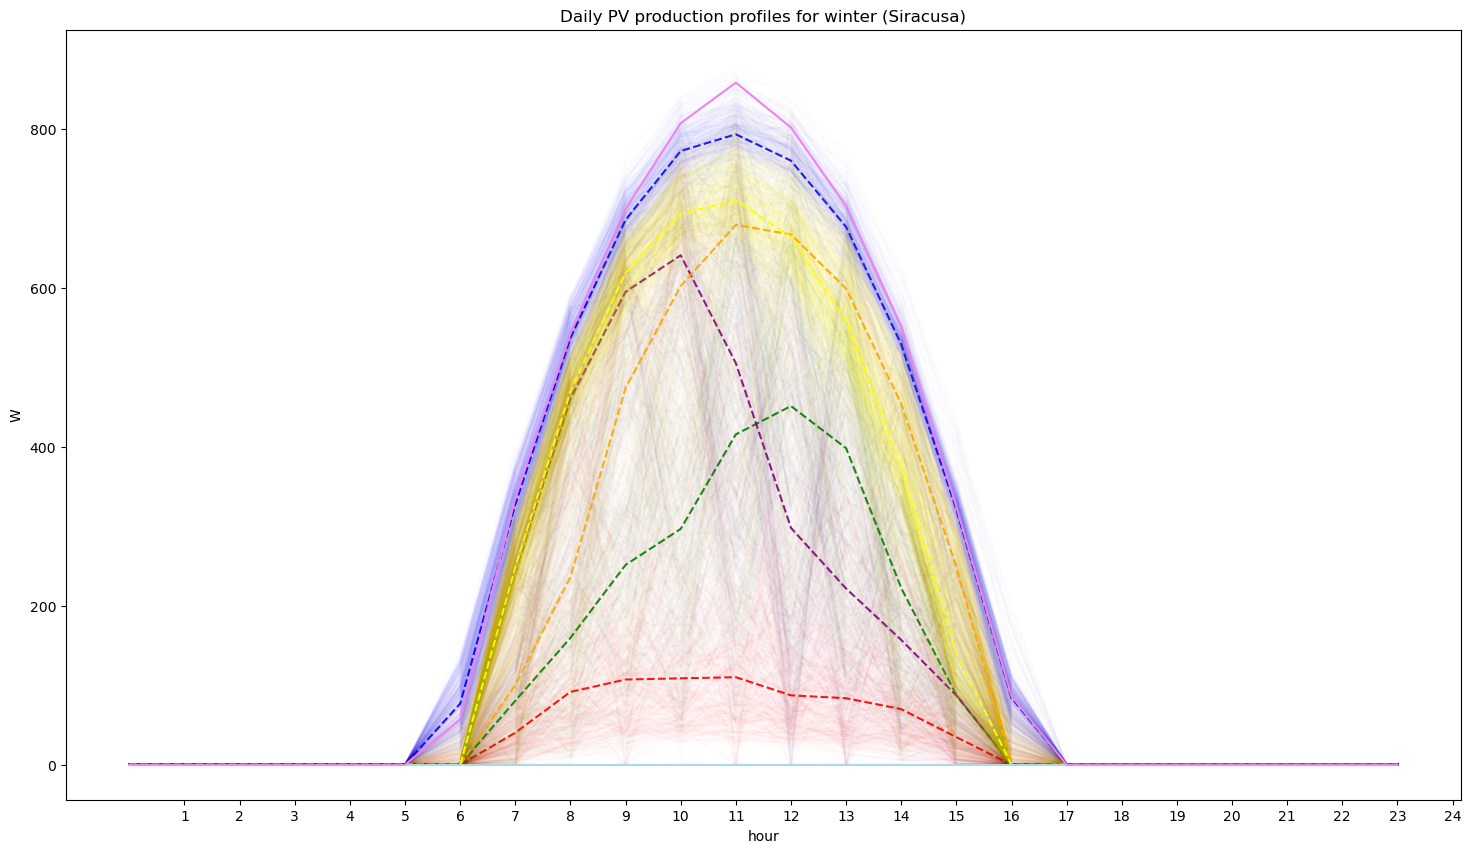

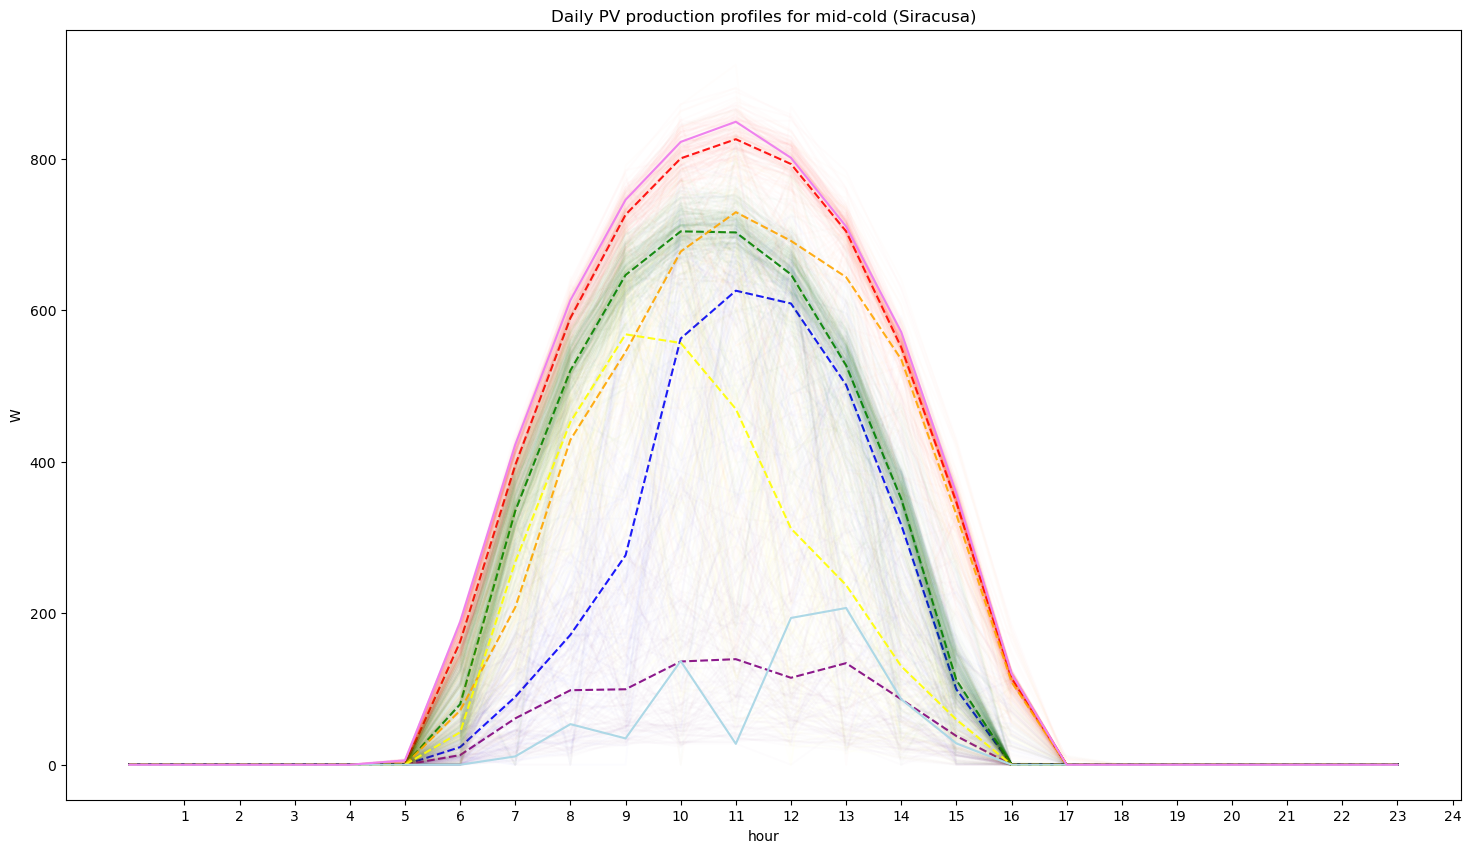

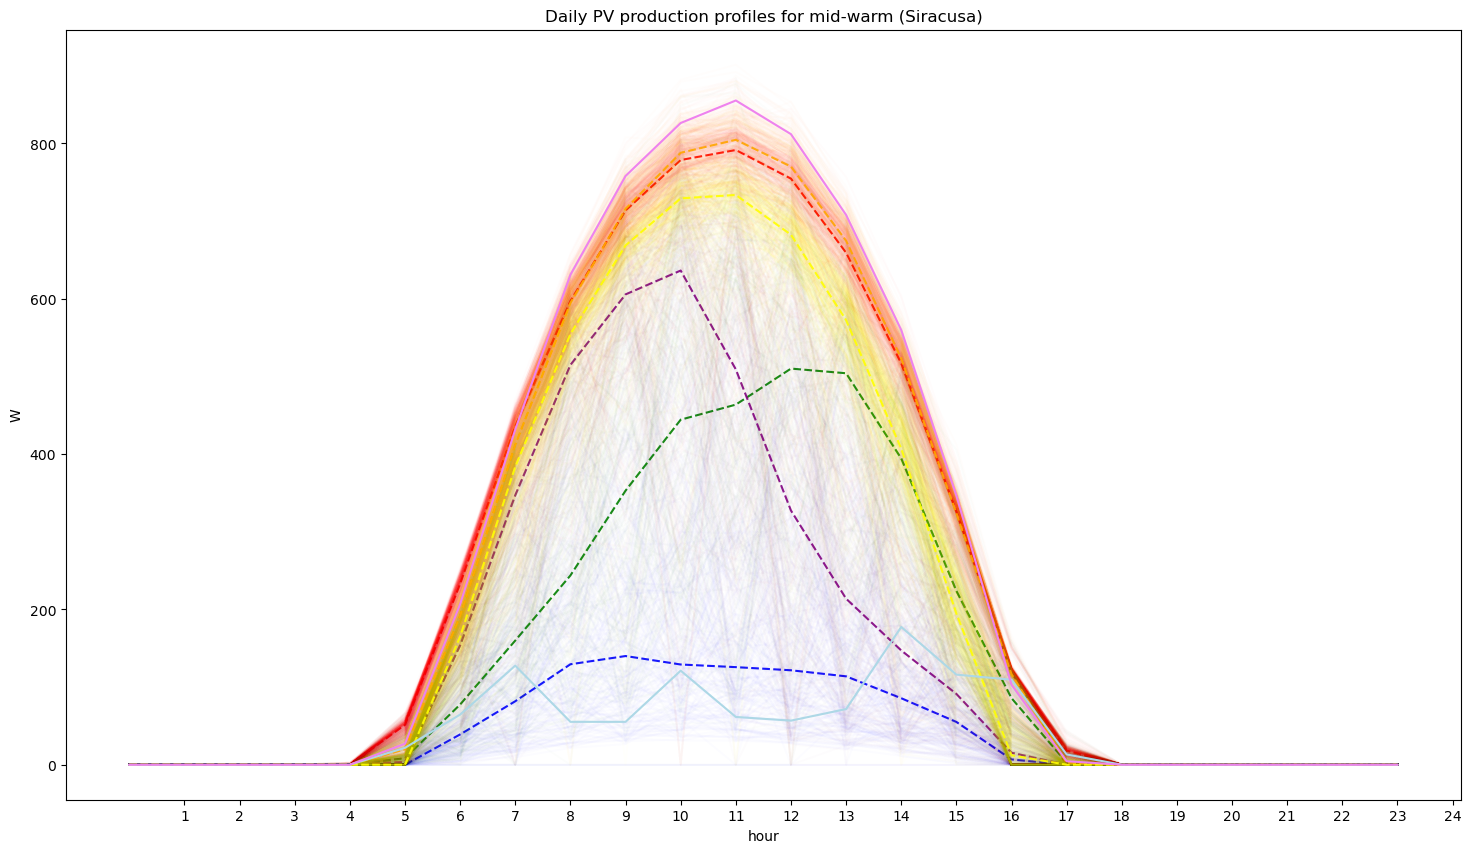

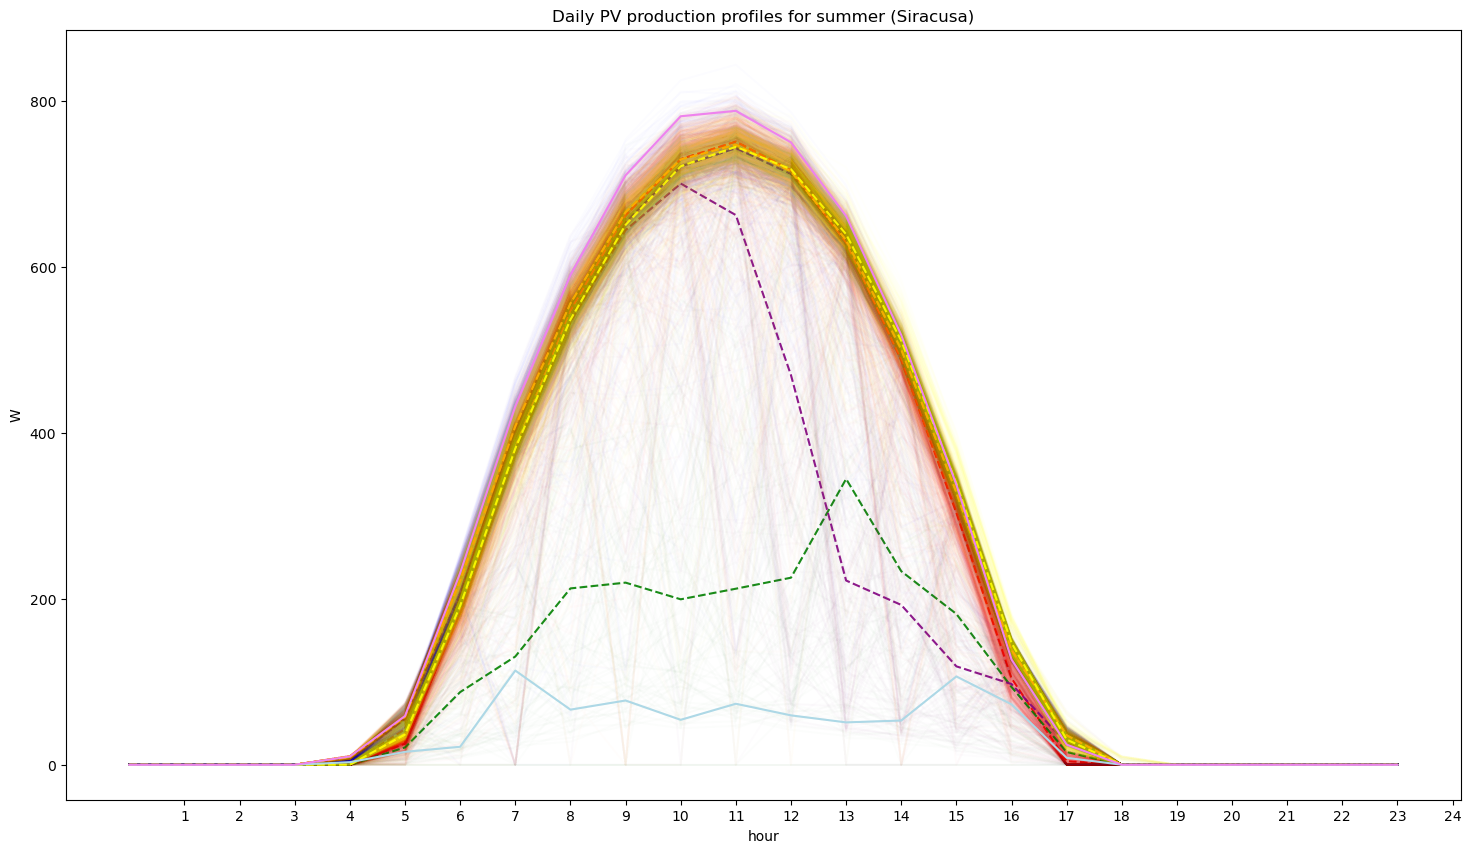

In [3]:
#Preparing for clustering
X=raw[['Date','Hour','P','Season']]
X['P'] = X['P'].fillna(0)
X['data'] = pd.to_datetime(X['Date'])

#Pivoting by date
pivot_data = raw.pivot_table(index='Date', columns='Hour', values='P')
pivot_data = pivot_data.fillna(0)

#CLUSTERING (from towardsdatascience.com)
K=6
daily_production = raw.groupby(['Date', 'Season'])['P'].sum().reset_index()
daily_production['Cluster'] =-1

centroids_df = pd.DataFrame()
Profiles=pd.DataFrame()
Profiles.index=range(1,25)
for s in seasons:
    # Pivot dei dati per ottenere un formato in cui ogni riga rappresenta un giorno e ogni colonna rappresenta un'ora
    X_season=X[X['Season']==s]
    X_pivot=X_season.pivot(index='Date', columns='Hour', values='P')
    X_pivot=X_pivot.fillna(0)

    # Riordinare le colonne per assicurarsi che siano in ordine da 0 a 23
    X_pivot = X_pivot[sorted(pivot_data.columns)]

    A=X_pivot.values.copy()

    sc = MinMaxScaler()
    A = sc.fit_transform(A)

    #Clustering
    kmeans = KMeans(n_clusters=K)
    cluster_found = kmeans.fit_predict(A)
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    X_pivot = X_pivot.set_index(cluster_found_sr, append=True )

    centroids = kmeans.cluster_centers_

    season_mask=daily_production['Season']==s
    daily_production.loc[season_mask,'Cluster'] = cluster_found

    # # Aggiungere i centroidi al DataFrame centroids_df
    # centroids_df_season = pd.DataFrame(centroids, columns=sorted(X_pivot.columns))
    # centroids_df_season['Season'] = s
    # centroids_df_season['Cluster'] = range(K)

    # # Aggiungere i centroidi al DataFrame centroids_df
    # centroids_df = pd.concat([centroids_df, centroids_df_season], ignore_index=True)

    fig, ax= plt.subplots(1,1, figsize=(18,10))
    color_list = ['blue','red','green','purple','orange','yellow']
    cluster_values = sorted(X_pivot.index.get_level_values('cluster').unique())

    for cluster, color in zip(cluster_values, color_list):
        X_pivot.xs(cluster, level=1).T.plot(
            ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
        X_pivot.xs(cluster, level=1).median().plot(
            ax=ax, color=color, alpha=0.9, ls='--'
        )

    for i in range(K):
        Profiles[f'{s}_{i+1}']=X_pivot.xs(i, level=1).median().values.copy()
    
    Profiles[f'{s}_min']=raw[raw['Date'] == min_prod_dates[s]][['P']].values.copy()
    Profiles[f'{s}_max']=raw[raw['Date'] == max_prod_dates[s]][['P']].values.copy()
    plot_min = pd.Series(Profiles[f'{s}_min'])
    plot_min.index = range(24)  
    plot_max=Profiles[f'{s}_max']
    plot_max.set_axis(range(0,24),axis=0)
    ax.plot(range(24),plot_min,label='Min',color='lightblue')
    ax.plot(range(24),plot_max,label='Max',color='violet')
    ax.set_xticks(np.arange(1,25))
    ax.set_ylabel('W')
    ax.set_xlabel('hour')
    ax.title.set_text(f'Daily PV production profiles for {s} (Siracusa)')
    plt.savefig(f'graphsPV/Siracusa2_{s}.png')

#Profiles.to_csv('PV_profiles.csv', index=False)

In [4]:
Profiles.to_csv('Siracusa2_PV_profiles.csv', index=False)

In [5]:
# Seasonal parameters: days per season -2 per min and max
season_days = {
    'winter': 103,
    'mid-cold': 44,
    'mid-warm': 89,
    'summer': 121
}

df_index=['day1','day2','day3','day4','day5','day6','day7','day8','day9','day10','day11','day12','day13','day14']

Prepare coefficients (for DPT) and PV capacity factor -> export excel

In [6]:
random_sequence=pd.DataFrame()
coeff_sequence=pd.DataFrame()
coefficients=pd.DataFrame(columns=seasons,index=df_index)
daily_sum=pd.DataFrame(columns=seasons,index=df_index)
new_coefficients=pd.DataFrame(columns=seasons,index=df_index)
deltaC=pd.DataFrame(columns=seasons,index=df_index)
for s in seasons:
    #Report the distrubition coefficients of clusters
    season_data = daily_production[daily_production['Season'] == s]
    cluster_counts = season_data['Cluster'].value_counts(normalize=True)
    
    #Build sequence of daus and coefficients as found by clusteting
    days_sequence=pd.DataFrame()
    for i in range(1,7):
        days_sequence[f'day{i}']=Profiles[f'{s}_{i}']
        coeff_sequence[f'day{i}']=[cluster_counts[i-1]*season_days[s]/2]
    for i in range(7,13):
        days_sequence[f'day{i}']=Profiles[f'{s}_{i-6}']
        coeff_sequence[f'day{i}']=[cluster_counts[i-7]*season_days[s]/2]      
    days_sequence['day13']=Profiles[f'{s}_max']    
    days_sequence['day14']=Profiles[f'{s}_min']       
    coeff_sequence['day13']=coeff_sequence['day14']=[1]
    
    order = list(range(1,15))
    random.shuffle(order)

    #Build the sequence of shuffled days, dividing weekdays and holidays
    for i in range(14):
        random_sequence[f'{s}{i+1}_{df_index[i]}']=days_sequence[f'day{order[i]}']
        coefficients.loc[df_index[i],s]=coeff_sequence[f'day{order[i]}'][0]
        daily_sum.loc[df_index[i],s]=random_sequence[f'{s}{i+1}_{df_index[i]}'].sum()
    
    coefficients[s]=pd.to_numeric(coefficients[s],errors='coerce') 
  

In [7]:
#Create days per type dataframe
days_per_type=pd.DataFrame(columns=['days_names','values'],index=range(57))
for i in range(57):
    if i<9:
        days_per_type.loc[i,'days_names']=f'winter0{i+1}'
        days_per_type.loc[i,'values']=coefficients.loc[df_index[i],'winter']
    elif i<14:
        days_per_type.loc[i,'days_names']=f'winter{i+1}'
        days_per_type.loc[i,'values']=coefficients.loc[df_index[i],'winter']
    elif i<23:
        days_per_type.loc[i,'days_names']=f'mid-cold0{i-13}'
        days_per_type.loc[i,'values']=coefficients.loc[df_index[i-14],'mid-cold']
    elif i<28:
        days_per_type.loc[i,'days_names']=f'mid-cold{i-13}'
        days_per_type.loc[i,'values']=coefficients.loc[df_index[i-14],'mid-cold']
    elif i<37:
        days_per_type.loc[i,'days_names']=f'mid-warm0{i-27}'
        days_per_type.loc[i,'values']=coefficients.loc[df_index[i-28],'mid-warm']
    elif i<42:
        days_per_type.loc[i,'days_names']=f'mid-warm{i-27}'
        days_per_type.loc[i,'values']=coefficients.loc[df_index[i-28],'mid-warm']
    elif i<51:
        days_per_type.loc[i,'days_names']=f'summer0{i-41}'
        days_per_type.loc[i,'values']=coefficients.loc[df_index[i-42],'summer']
    elif i<56:
        days_per_type.loc[i,'days_names']=f'summer{i-41}'
        days_per_type.loc[i,'values']=coefficients.loc[df_index[i-42],'summer']
    elif i==56:
        days_per_type.loc[i,'days_names']='peak'
        days_per_type.loc[i,'values']=0
days_per_type.to_excel('Siracusa_DPT.xlsx',index=False)

#Export profiles as capacity factors for PV
cf=pd.DataFrame(columns=['time_h','values'])
j=0
season_short=['wi','mc','mw','su']
for s in range(4):
    for i in range(1,15):
        profile_column=random_sequence.loc[:, random_sequence.columns.str.contains(f'{seasons[s]}{i}_')]
        if i<10:
            for h in range(1,25):
                if h<10:
                    cf.loc[j,'time_h']=f'h0{h}_{season_short[s]}0{i}'
                    cf.loc[j,'values']=profile_column.iloc[h-1,0]/1000
                    j+=1
                else:
                    cf.loc[j,'time_h']=f'h{h}_{season_short[s]}0{i}'
                    cf.loc[j,'values']=profile_column.iloc[h-1,0]/1000
                    j+=1
        else:
            for h in range(1,25):
                if h<10:
                    cf.loc[j,'time_h']=f'h0{h}_{season_short[s]}{i}'
                    cf.loc[j,'values']=profile_column.iloc[h-1,0]/1000
                    j+=1
                else:
                    cf.loc[j,'time_h']=f'h{h}_{season_short[s]}{i}'
                    cf.loc[j,'values']=profile_column.iloc[h-1,0]/1000
                    j+=1
cf.loc[1344,'time_h']='peak'
cf.loc[1344,'values']=0
cf.to_excel('Siracusa_cf_PV.xlsx',index=False)